In [1]:
# Install missing packages
!pip install -q sentence-transformers bertopic transformers torch umap-learn hdbscan

# Standard imports
import pandas as pd
import numpy as np
import nltk
import re
from collections import Counter
from transformers import pipeline
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# NLTK downloads
nltk.download('punkt', quiet=True)

print("✅ Libraries loaded")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.1 MB/s eta 0:00:00


2025-10-01 16:25:07.453492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759335907.776099      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759335907.874445      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Libraries loaded


In [2]:
# Load sample patient call transcripts
df = pd.read_csv("/kaggle/input/sample-calls-csv/sample_calls.csv")

print("=== Patient Call Dataset ===")
print(f"Total calls: {len(df)}")
df.head()




=== Patient Call Dataset ===
Total calls: 10


,call_id,patient_id,timestamp,transcript
0,1,1001,2024-09-01T10:05:00Z,"""Hello, I need to reschedule my appointment wi..."
1,2,1002,2024-09-01T11:20:00Z,"""My prescription for blood pressure meds ran o..."
2,3,1003,2024-09-02T09:15:00Z,"""I've been having headaches and nausea for two..."
3,4,1004,2024-09-03T14:00:00Z,"""I need instructions on how to take the new me..."
4,5,1005,2024-09-04T08:45:00Z,"""Is there a nurse line? I want to ask about my..."


In [3]:
# Step 3: Preprocess & Tokenize Text
# Function to clean and tokenize text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    tokens = nltk.word_tokenize(text)
    return tokens

# Apply preprocessing
df["tokens"] = df["transcript"].apply(preprocess_text)

# Show most common words across all calls
all_tokens = [token for tokens in df["tokens"] for token in tokens]
common_words = Counter(all_tokens).most_common(10)

print("=== Most Common Words ===")
for word, freq in common_words:
    print(f"{word}: {freq}")


=== Most Common Words ===
i: 13
my: 5
a: 5
to: 4
need: 3
for: 3
can: 3
should: 3
appointment: 2
ive: 2


In [4]:
##Step 4: Summarize Calls (Dynamic Max Length)
print("=== Summarizing Patient Calls ===")

# Initialize summarizer (BART model)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Function to summarize a single transcript dynamically
def summarize_call(text, min_length=5, max_length_cap=40):
    input_len = len(text.split())  # rough word count
    max_len = min(max_length_cap, max(min_length, input_len))  # ensure max_len >= min_length
    summary = summarizer(text, max_length=max_len, min_length=min_length, do_sample=False)[0]["summary_text"]
    return summary

# Summarize first 3 calls for demo
for i, doc in enumerate(df["transcript"][:3]):
    summary = summarize_call(doc)
    print(f"\nCall {i+1} Summary:")
    print(summary)


=== Summarizing Patient Calls ===


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu



Call 1 Summary:
"I need to reschedule my appointment

Call 2 Summary:
"My prescription for blood pressure meds ran out

Call 3 Summary:
"I've been having headaches and nausea for two


In [5]:
print("=== Summarizing All Patient Calls ===")

# Summarize all transcripts dynamically
df['summary'] = df['transcript'].apply(lambda x: summarize_call(x))

# Display first few summaries
df[['call_id', 'transcript', 'summary']].head(5)


=== Summarizing All Patient Calls ===


,call_id,transcript,summary
0,1,"""Hello, I need to reschedule my appointment wi...","""I need to reschedule my appointment"
1,2,"""My prescription for blood pressure meds ran o...","""My prescription for blood pressure meds ran out"
2,3,"""I've been having headaches and nausea for two...","""I've been having headaches and nausea for two"
3,4,"""I need instructions on how to take the new me...","""I need instructions on how to take the new"
4,5,"""Is there a nurse line? I want to ask about my...","""Is there a nurse line? I want to"


In [6]:
#Topic Modeling on Summaries
print("=== Running BERTopic on Summaries ===")

# Load sentence transformer embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Initialize BERTopic
topic_model = BERTopic(embedding_model=embedding_model)

# Fit BERTopic on summaries instead of full transcripts
topics, probs = topic_model.fit_transform(df['summary'].tolist())

# Add topic assignments to dataframe
df['topic'] = topics

# Display topic info
topic_info = topic_model.get_topic_info()
topic_info



=== Running BERTopic on Summaries ===


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,10,-1_my_to_for_ve,"[my, to, for, ve, take, need, been, back, appo...","[""I've been having headaches and nausea for tw..."


In [7]:
#Display Top Words per Topic
print("=== Topics and Top Words ===")

for topic_id in topic_info["Topic"]:
    print(f"\nTopic {topic_id}:")
    words = topic_model.get_topic(topic_id)
    if words:
        print(", ".join([w[0] for w in words]))
    else:
        print("No words for this topic")

#Includes outlier topic -1 automatically.

#Works even if dataset has only a few calls.

=== Topics and Top Words ===

Topic -1:
my, to, for, ve, take, need, been, back, appointment, cold


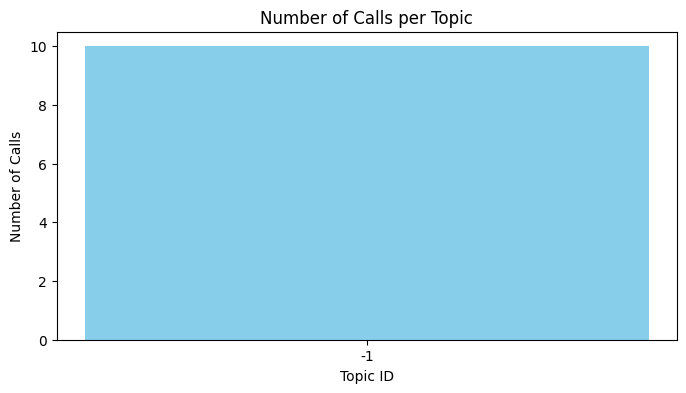

In [8]:

#Manually creating a simple Pandas table or bar chart of topics and their top words. 
#This is robust and works with the small dataset size.
import matplotlib.pyplot as plt

# Count documents per topic (including -1)
topic_sizes = topic_info[["Topic", "Count"]]

plt.figure(figsize=(8,4))
plt.bar(topic_sizes["Topic"].astype(str), topic_sizes["Count"], color='skyblue')
plt.xlabel("Topic ID")
plt.ylabel("Number of Calls")
plt.title("Number of Calls per Topic")
plt.show()



In [9]:
# Show call_id, summary, and assigned topic
df[['call_id', 'summary', 'topic']].head(10)


,call_id,summary,topic
0,1,"""I need to reschedule my appointment",-1
1,2,"""My prescription for blood pressure meds ran out",-1
2,3,"""I've been having headaches and nausea for two",-1
3,4,"""I need instructions on how to take the new",-1
4,5,"""Is there a nurse line? I want to",-1
5,6,"""I’ve been",-1
6,7,"""Can I book an appointment",-1
7,8,"""My test results came back, but I don�",-1
8,9,"""I’m experiencing some pain in my lower back",-1
9,10,"""I think I have a cold. Should I take",-1


In [10]:
# Save Processed Data to CSV
# Create output folder if it doesn't exist
import os
output_dir = "/kaggle/working/output"
os.makedirs(output_dir, exist_ok=True)

# Save processed dataframe with summaries and topic assignments
df.to_csv(f"{output_dir}/patient_calls_processed.csv", index=False)

# Save topic information separately
topic_info.to_csv(f"{output_dir}/patient_call_topics.csv", index=False)

print(f"✅ Processed data saved to {output_dir}/")


✅ Processed data saved to /kaggle/working/output/
